# Time Series Anomaly Detection

We will use a concept known as **Bollinger Bands** to discover when behavior changes from what is "expected" or normal. **Bollinger Bands** is a volatility indicator and commonly used in stock, forex, and cryptocurrency market trading to execute mean reversion strategies.

<u>Scenario</u>: Discover anomalies in number of web pages accessed in a day by a user. Is there a bot copying the curriculum?

We will accomplish this by breaking down to the following tasks:

1. Acquire the data
1. Prepare the data
1. Make the analysis process (which we will discuss later) work over all users.
1. Turn the analysis process and calculations into a function that can be used to loop through for each user.
1. Test the function on a single user.
1. Analyze by looping over all users.

The analysis process will look like this, for each user:

1. Compute necessary metrics to arrive at the final metric, %b (percent-b).
1. Add user id to the dataframe that contains all the metrics, including %b.
1. Filter to rows where %b indicates anomaly (i.e. > 1)
1. Append rows of anomalies of new user to previous users' anomalous activity.

Finally, we will do a quick sample of exploration of the anomalies. There is much more you can do!

Your exercise will be to add comments, markdown, and docstrings to the code in this lesson.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

## Acquire

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly.

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''
df = pd.read_sql(query, url)
print(df.shape)
df.head()

(900223, 5)


,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


## Prepare

1. Convert `date` column to datetime class
2. Set `date` column as the index for the dataframe
3. Resample at a daily frequency using `count()` as the aggregation method

In [3]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<Axes: xlabel='date'>

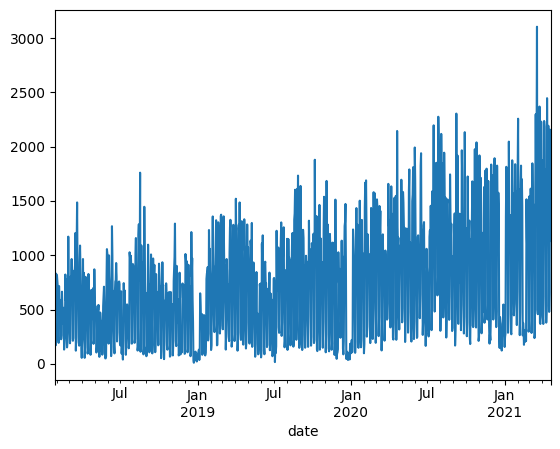

In [4]:
pages.plot()

There is no need to split because we are not modeling. We are only exploring to identify low probability cases.

### Exponential Moving Average
Simple Moving Average (SMA) time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. For datasets that contain rapid trend shifts, a SMA may simply be too slow to be useful. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this:

### EMA<sub>*t*</sub> = (*t*<sub>0</sub> * ( a / (1 + M))) + EMA<sub>*t−1*</sub> * (1 - ( a / (1 + M)))

Where:

- t<sub>0</sub> = Latest value
- t<sub>−1</sub> = Previous value
- EMA<sub>*t−1*</sub> = Exponential moving average of previous day.
- a = the smoothing constant (determines the degree of weight given to more recent values)
- M = Number of time periods, span of the window 

> Note: The actual amount of weight given to the more recent values is determined by both the smoothing constant **and** M, the number of periods being evaluated. The shorter the time period, the more weight is given to more recent values.

Because the EMA formula is dependent on the previous time period's EMA, the first EMA is actually calculated as a simple moving average (SMA).

Instead of calculating EMA manually, we will use the pandas `ewm()` (Exponential Weighted functions) to compute our EMA. So we just need to define the following:

M = `span` = number of time periods. We will try 7 days, 14 days, and 30 days.

> There are other parameters that can be included in the function call that alters the weighting in various ways.

In [5]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

Notice how there are no missing values. `ewm()` will use as many values as are available to compute the mean. 

So if the span is 7 days, but there is only one day of data available (i.e. the first day), the EMA will equal the first value.

In [6]:
ema_7d[0] == pages[0]

True

In [7]:
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

In [8]:
# 14 day EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [9]:
# 30 day EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [10]:
# 90 day EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

> Remember! These are *exponential* moving averages, not simple! Notice that as the time period lengthens, the values begin to approximate a simple moving average. 

In [11]:
# 900000000 day EMA
ema_90d = pages.ewm(span=900_000_000).mean()
ema_90d.head()

date
2018-01-26    572.0
2018-01-27    401.0
2018-01-28    324.0
2018-01-29    450.5
2018-01-30    490.8
Freq: D, Name: endpoint, dtype: float64

This ridiculously long EMA period has essentially created a SMA.

Lets plot our EMAs against each other:

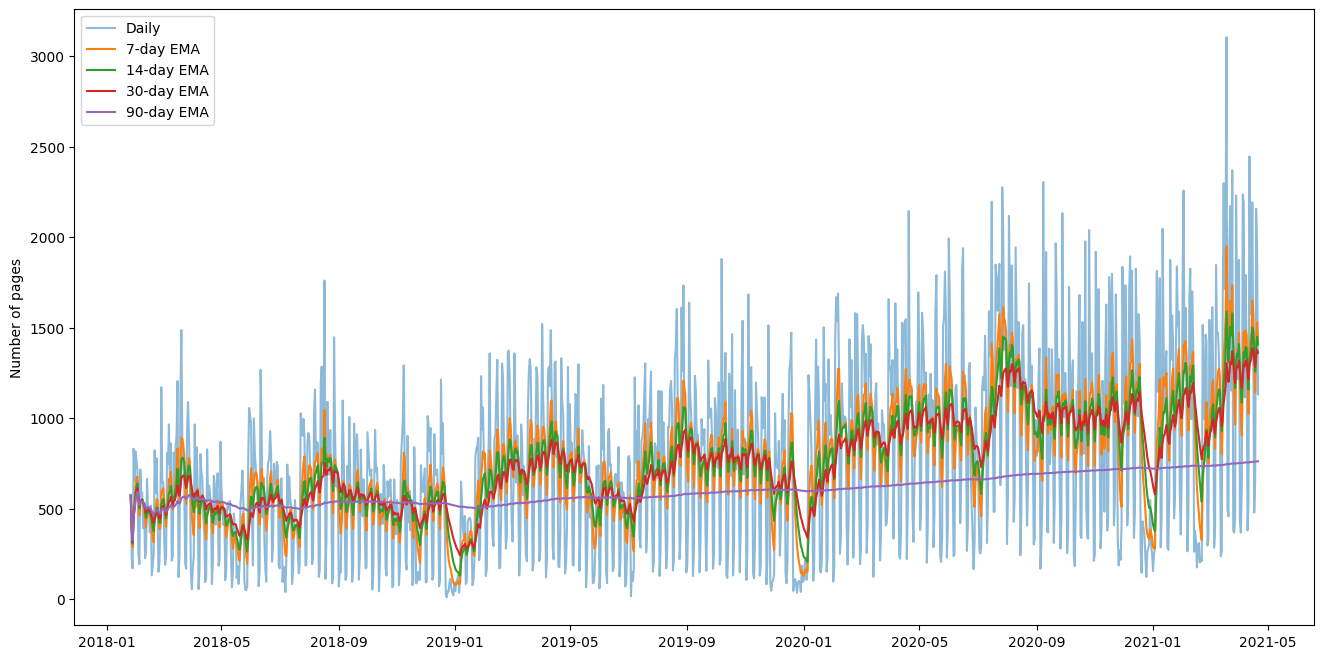

In [12]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

Let's look at a smaller date range to see how these EMAs react to changes in value:

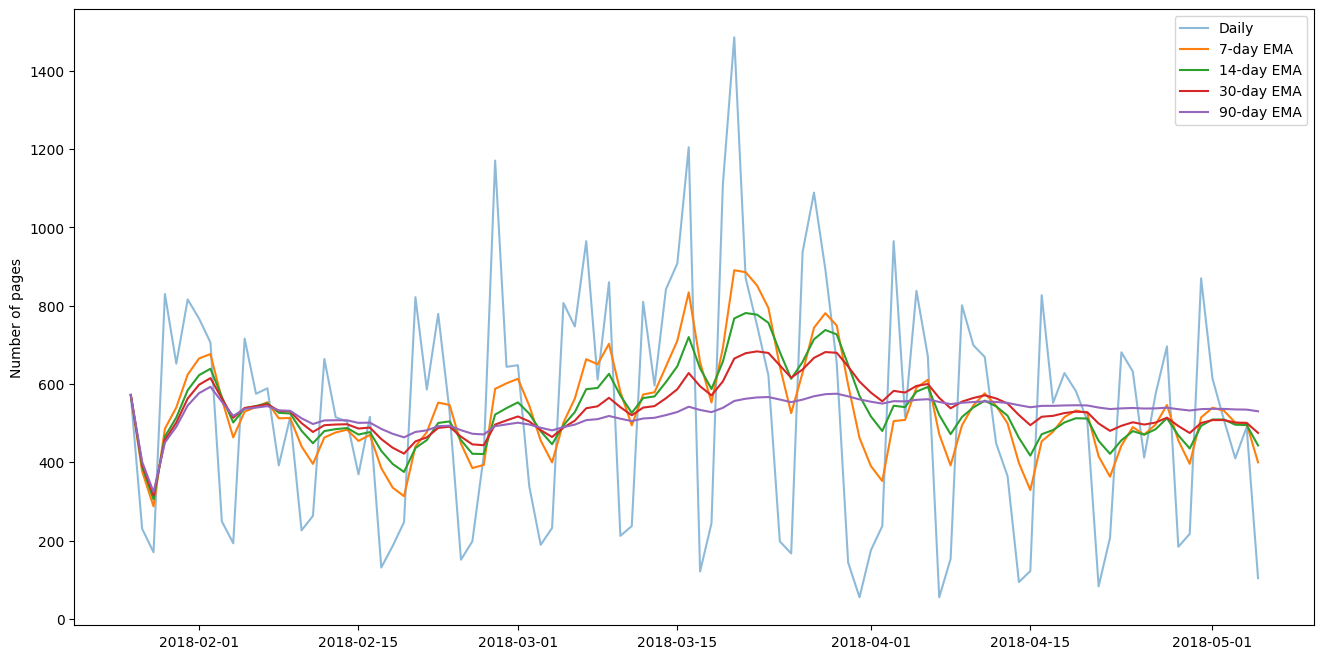

In [13]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index[:100], pages[:100], label='Daily', alpha=.5)
ax.plot(pages.index[:100], ema_7d[:100], label = '7-day EMA')
ax.plot(pages.index[:100], ema_14d[:100], label = '14-day EMA')
ax.plot(pages.index[:100], ema_30d[:100], label = '30-day EMA')
ax.plot(pages.index[:100], ema_90d[:100], label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Bollinger Bands

- A volatility indicator commonly used in stock market, forex, and cryptocurrency trading.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.
- Based on the exponential moving average

### Midband

The Exponential Moving Average

`midband = train.ewm(span=30).mean()`

### Upper & Lower Band

UB/LB = Midband +/- stdev * K

`stdev = train.ewm(span=30).std()`

K = the number of standard deviations to go up and down from the EMA

### %b, Percent Bandwidth

Shows where the last value sits in relation to the bands.

%b = last−LB / UB-LB

- If %b > 1, data point lies above the upper band
- If %b < 0, data point lies below the lower band
- If %b == .5, data point lies on the midband.

### Bandwidth

The width of the bands

Bandwidth = (UB-LB) / midband

In [14]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [15]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [16]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub, lb

(date
 2018-01-26            NaN
 2018-01-27    1120.791557
 2018-01-28     956.773991
 2018-01-29    1406.405897
 2018-01-30    1354.808245
                  ...     
 2021-04-17    3545.216722
 2021-04-18    3486.733695
 2021-04-19    3569.147958
 2021-04-20    3579.231798
 2021-04-21    3499.094360
 Freq: D, Name: endpoint, Length: 1182, dtype: float64,
 date
 2018-01-26           NaN
 2018-01-27   -330.191557
 2018-01-28   -326.494835
 2018-01-29   -492.401124
 2018-01-30   -352.070116
                  ...    
 2021-04-17   -894.858492
 2021-04-18   -922.334061
 2021-04-19   -891.999913
 2021-04-20   -825.770723
 2021-04-21   -777.340451
 Freq: D, Name: endpoint, Length: 1182, dtype: float64)

In [17]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [18]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


### Plot the bands

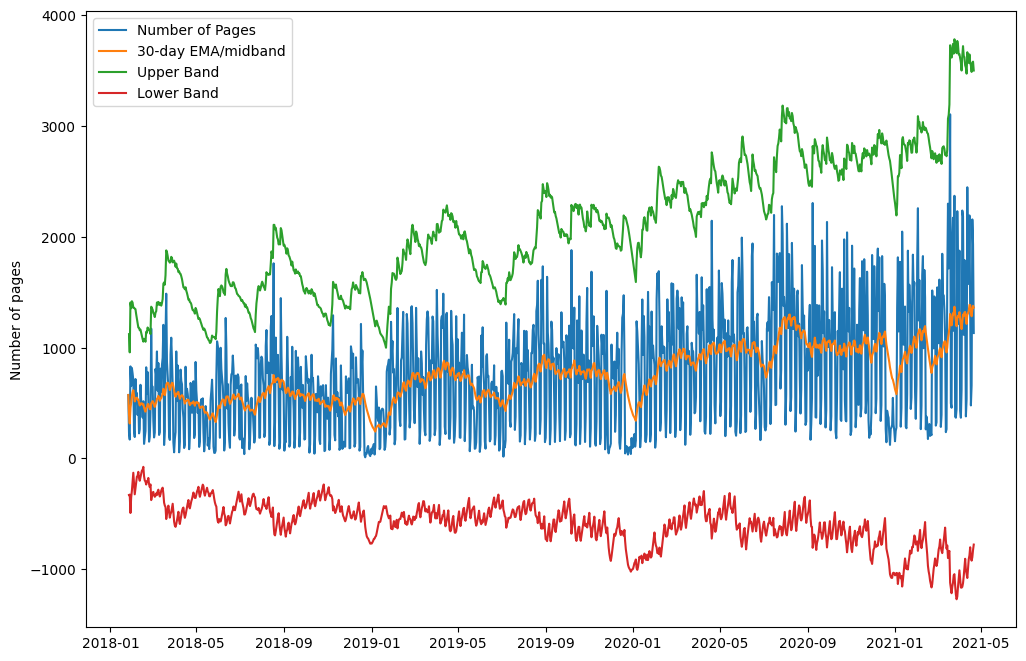

In [19]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

### Compute %b

Each data point will have a %b value that represents its relative position within/around the bollinger bands. It answers the question: Where does this point sit relative to a simple range of expected values? 

Lets manually compute %b for the last value in the dataset:

In [20]:
# Visualize the last record in our dataset
my_df.iloc[-1]

pages      1131.000000
midband    1360.876954
ub         3499.094360
lb         -777.340451
Name: 2021-04-21 00:00:00, dtype: float64

In [21]:
# get the value of the last record
last_measure = my_df.iloc[-1].pages
last_measure

1131.0

In [22]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-777.340451135389

In [23]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

3499.0943598250406

In [24]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.45


We can add a new column that shows the %b for every record in the dataset (except the first because there are no bollinger bands available for that one record)

In [25]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


Now, where do we see anomalies? We will search for %b values > 1. In this specific example, we don't need to search for values < 0 because a low extreme is not something we are concerned about. 

In [26]:
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


No anomalies found. Remember, the cutoff is based on the arbitrary selection for K earlier. We could always pick a different K.

Anyways great! There are no anomalies! Problem solved. 

...not so fast.

During our preparation step we resampled the data to a daily period. The bollinger bands and %b are only looking for individual days where the overall aggregate log activity was extreme. If the number of users is large enough, then an individual who is scraping our data may not be extreme enough to push a single day that far from the EMA. 

We need to dig deeper. Lets look at our data on a user by user basis:

In [27]:
def acquire_logs(user=env.user, password=env.password, host=env.host):
    '''
    This function queries the Codeup MySQL curriculum_logs database and returns a dataframe
    '''
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

In [28]:
def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

In [29]:
def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

In [30]:
def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

In [31]:
def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

# Using our functions:

In [32]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
date,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [33]:
df.shape

(900223, 5)

#### Test function on a single user:

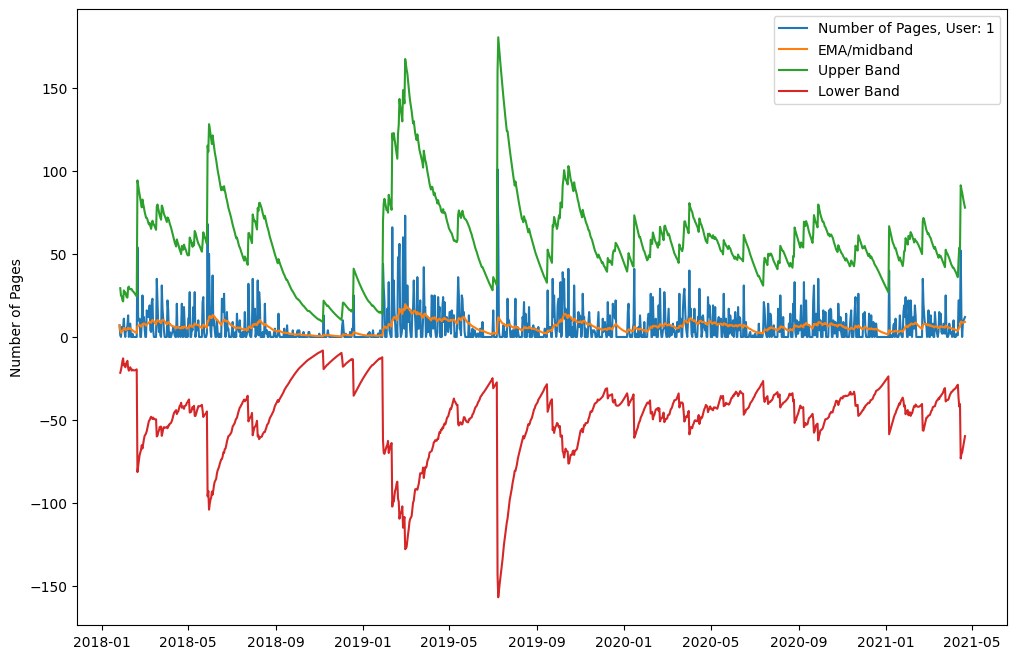

In [34]:
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight, plot=True)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [35]:
anomalies.head()

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,


No daily anomalies for user 1

#### Use function in a loop examining all users:

In [36]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [37]:
anomalies

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-01-24,7,0.574393,6.857226,-5.708440,1.011362,817
2021-03-25,59,6.824556,58.415342,-44.766230,1.005666,843
2021-02-23,67,8.229409,66.322904,-49.864086,1.005828,851


What if we sort by %b?

In [38]:
anomalies.sort_values(by='pct_b', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-12-24,1,0.064516,0.939061,-0.810028,1.034841,232
2020-12-16,12,0.774194,11.268729,-9.720342,1.034841,156
2020-09-13,4,0.258065,3.756243,-3.240114,1.034841,210
2020-05-12,16,1.032258,15.024972,-12.960456,1.034841,93
2019-09-12,16,1.032258,15.024972,-12.960456,1.034841,94
...,...,...,...,...,...,...
2021-03-23,146,26.440411,145.913292,-93.032470,1.000363,581
2020-09-17,24,2.103030,23.984360,-19.778300,1.000357,560
2020-10-27,17,1.232625,16.991469,-14.526220,1.000271,613


Not super useful. Looks like there could be a fair number of "false positives" here. Lets sort by the page counts:

In [39]:
anomalies.sort_values(by='pages_one_user', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2018-06-02,198,16.484863,188.766965,-155.797239,1.026796,138
2019-12-19,192,19.601776,187.231096,-148.027544,1.014225,526
2020-10-16,179,20.158062,173.720239,-133.404115,1.017191,658
2020-06-05,165,20.035882,163.037501,-122.965736,1.006862,521
...,...,...,...,...,...,...
2019-05-21,1,0.064519,0.939144,-0.810106,1.034790,19
2020-11-21,1,0.065202,0.959398,-0.828994,1.022703,410
2019-03-20,1,0.064516,0.939061,-0.810029,1.034841,126


#### Wow! User_id #341 looked at 272 pages in a single day. Lets plot their activity:

In [40]:
df_341 = one_user_df_prep(df, 341)

<Axes: xlabel='date'>

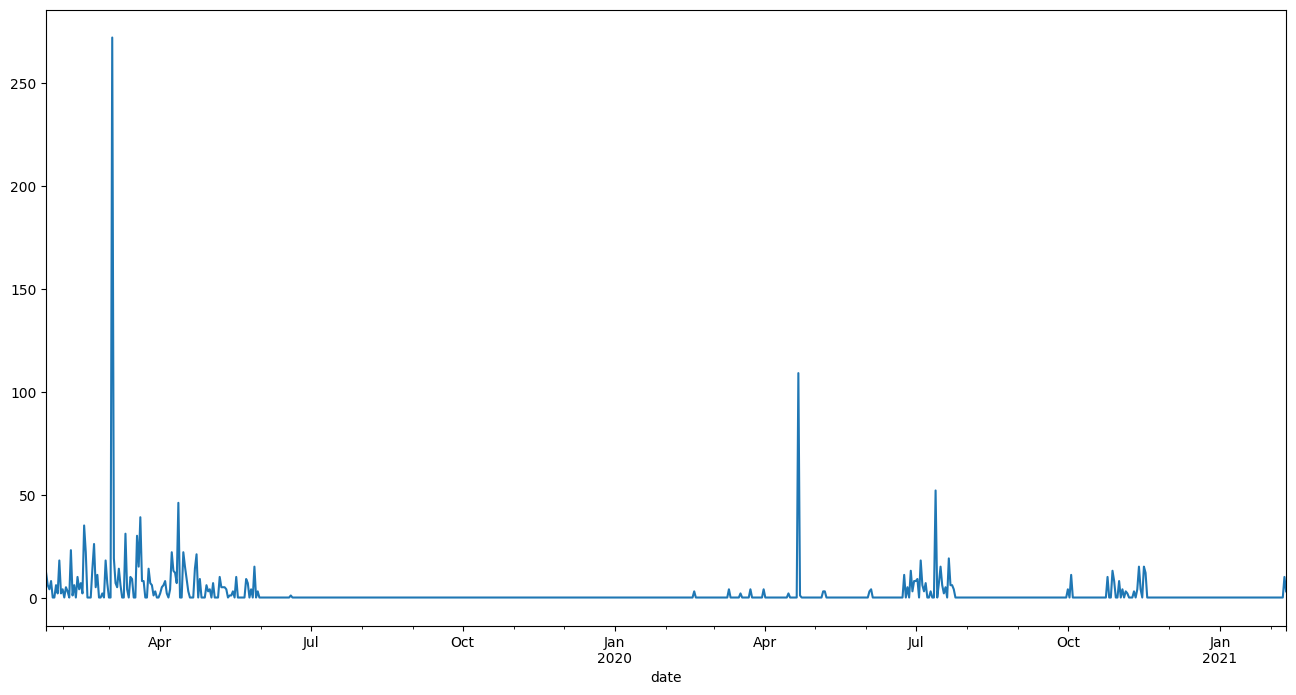

In [41]:
df_341.plot(figsize=(16,8))

Are there users that show up more frequently than others?

In [42]:
anomalies.user_id.value_counts()

user_id
88     12
146    11
80     11
18     10
291     9
       ..
526     1
527     1
528     1
206     1
859     1
Name: count, Length: 413, dtype: int64

Let's plot user #88:

<Axes: xlabel='date'>

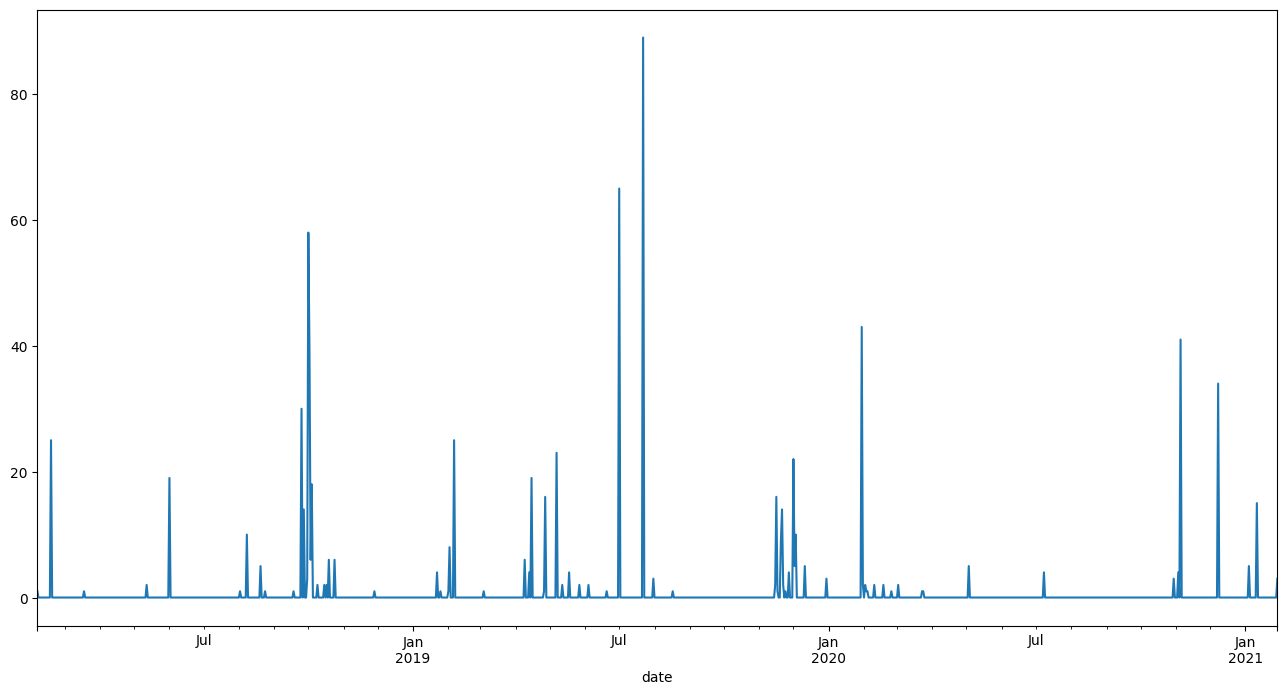

In [43]:
df_88 = one_user_df_prep(df, 88)
df_88.plot(figsize=(16,8))

# SUSPICIOUSSSSS... {ಠʖಠ}

# Exercises
- file name: `time_series_anomaly_detection.py` or `time_series_anomaly_detection.ipynb`

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

**Hint**: You will need to explore the database (yay SQL!)

1. Label students by the program they are in.
1. Is it possible to identify the user_id of a staff member?
1. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
1. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 
1. Plot the access activity of these students.

**BONUS:** Can you identify users who are viewing both the web dev and data science curriculum?